# Распознавание возраста покупателей

### Вводная <a class="tocSkip">

Сеть торговых центров «Ultra Mall» хочет дополнить свою систему видеонаблюдения технологией компьютерного зрения. Обработка фотографий покупателей в торговых залах поможет определять возраст клиентов и решать следующие задачи:  
    
  • Классификация и составление портрета клиента для персонализации предложений;  
  • Контроль продаж алкоголя и табачных изделий несовершеннолетним.  
  

### Цель <a class="tocSkip">
    
    Построить модель, которая по фотографии определит приблизительный возраст человека. MAE модели должно быть меньше 8.

### Описание данных <a class="tocSkip">

В данном проекте используется APPA-REAL (real and apparent age) датасет.  
https://chalearnlap.cvc.uab.cat/dataset/26/description/
    
Датасет содержит 7 591 изображение с соответствующими метками реального возраста и его оценок (стандартная ошибка 0,3). 

Изображения разделены на 4113 изображений для обучающей, 1500 валидационной и 1978 тестовой выборки, они представленны в папках `train/`, `valid/` и `test/`. Реальный возраст и предполагаемый находятся в файлах `gt_train.csv, gt_test.csv и gt_valid.csv` с отдельной строкой для каждого возраста.

### План <a class="tocSkip">

    1. Проведение исследовательского анализа датасета фотографий.
    2. Подготовка данных к обучению.
    3. Обучение нейронной сети, оценка её качества.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

from sklearn.metrics import mean_absolute_error as mae

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Каждое изображение будем нормализовать, применив рескейлинг 1/255.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Перед нами таблица состоящая из пар `Название файла – его лейбл` (значение целевого признака). Пропусков нет.

### Распределение возраста в выборке

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


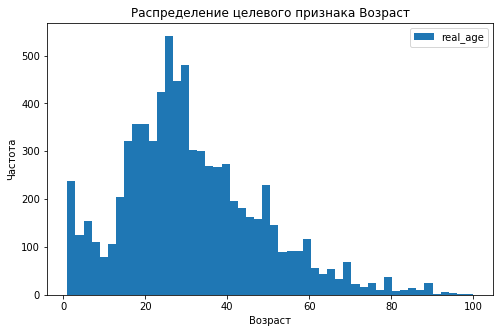

In [5]:
labels.plot(kind='hist', bins=50, figsize=(8, 5))
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение целевого признака Возраст');

На графике видно два пика значений – медианное значение около 28 - 29 лет, и пик возле минимального значения в 1 год. График имеет сдвиг влево. Среднее значение целевого признака 31.2 лет.

Проверим несколько изображений:

In [6]:
features, target = next(train_gen_flow)

Возраст: 50


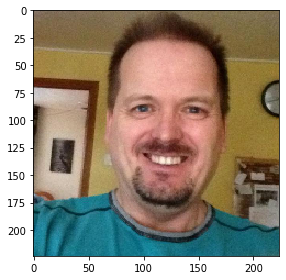

Возраст: 41


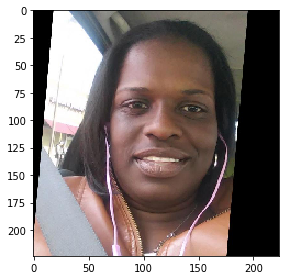

Возраст: 46


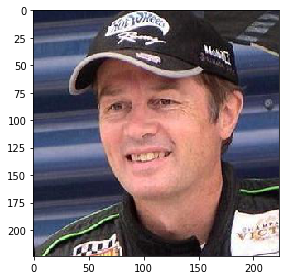

Возраст: 85


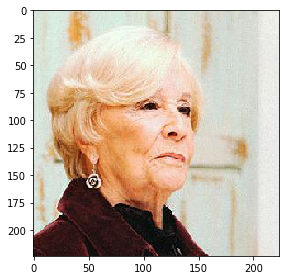

Возраст: 14


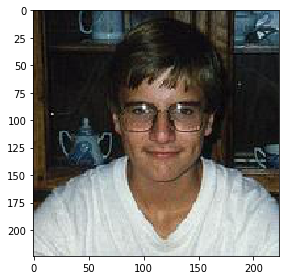

In [7]:
for i in range(5):
    print('Возраст:', target[i])
    plt.imshow(features[i]);
    plt.tight_layout()
    plt.show()

Всего в датасете 7591 цветных изображений с размеченным возрастом. Размерность изображений (224, 224, 3). Некоторые изображения (например второе) имеют черные поля. 

## Обучение модели

Сюда перенесён код обучения модели и её результат вывода на экран.

(Код в этом разделе запускается в отдельном GPU-тренажёре)

Опишем основные характеристики нашей модели:

В основе сети лежала остаточная CNN ResNet50 с весами, полученными на датасете 'imagenet'.
Модель решала задачу регрессии, поэтому в верхнем слое сети находился только 1 нейрон с активацией ReLU (для того, чтобы не было отрицательных значений возраста).

Для градиентной оптимизации использовался алгоритм Adam. Функция потерь MSE.

In [8]:
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                   #horizontal_flip = True,
                                   #vertical_flip = True,
                                   #rotation_range = 90,
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2,                                  
                                   rescale=1/255.)

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


In [9]:
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=12345)
    
    return test_datagen_flow

In [10]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape,
                    weights=None, #использовались weights='imagenet'
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, epochs=7, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

Результат работы на серевере:

```
Using TensorFlow backend.
Found 7591 validated image filenames.

2021-07-05 14:02:52.268596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

Train for 178 steps, validate for 60 steps
Epoch 1/7
2021-07-09 12:25:58.435451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-09 12:25:58.730125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 44s - loss: 240.5635 - mae: 11.0721 - val_loss: 713.3817 - val_mae: 21.7563
Epoch 2/7
178/178 - 37s - loss: 63.0755 - mae: 6.0254 - val_loss: 568.9130 - val_mae: 18.5429
Epoch 3/7
178/178 - 36s - loss: 31.5823 - mae: 4.3720 - val_loss: 214.0832 - val_mae: 11.3741
Epoch 4/7
178/178 - 36s - loss: 19.8097 - mae: 3.4605 - val_loss: 117.5576 - val_mae: 8.2374
Epoch 5/7
178/178 - 36s - loss: 15.1434 - mae: 3.0015 - val_loss: 102.7475 - val_mae: 8.0337
Epoch 6/7
178/178 - 36s - loss: 12.6724 - mae: 2.7891 - val_loss: 68.0625 - val_mae: 6.1752
Epoch 7/7
178/178 - 36s - loss: 9.7563 - mae: 2.4107 - val_loss: 65.8512 - val_mae: 6.1192


60/60 - 9s - loss: 65.8512 - mae: 6.1192
Test MAE: 6.1192

```

После обучения и валидации модели на сервере мы получили тестовое MAE = 6.1192. Наша модель ошибается в среднем на 6 лет на тестовой выборке. Далее мы сравним этот результат с работой dummy модели.  
60 тестовых батчей по 32 изображения было обработано за 9 секунд.

## Анализ обученной модели

In [12]:
model = create_model((224, 224, 3))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


В итоге у нас имеется 23,536,641 параметров, которые учит модель. В первом слое лежит модель ResNet, далее идет глобальный двумерный пулинг усреднением — пулинг с окном во весь тензор, который усредняет информацию по всему изображению. В конце находится 1 полносвязный нейрон с 2049 параметрами.

### Оценка модели

Посчитаем MAE dummy-модели. Модель будет предсказывать средний возраст выборки для каждого изображения.

In [14]:
dummy_mae = mae(labels['real_age'], np.full(len(labels), labels['real_age'].mean()))
dummy_mae

13.317217046353193

Вообще для корректной оценки модели мы должны были посчитать MAE только на тестовой выборке, однако мы воспользуемся допущением о том, что тестовая выборка репрезентирует генеральную совокупность и имеет те же свойства что и наша общая выборка. 

Если предсказывать возраст средним значением, MAE будет равно 13.3, что значительно менее точно чем предсказания нашей модели с MAE 6.1. 

В целом ошибка в 6 лет позволяет с хорошей точностью отнести человека к определенной возрастной категории. Для задачи анализа покупок и предложения товаров, которые могут заинтересовать покупателей нужной возрастной группы, модель подходит и рекомендована к использованию.

Для контроля добросовестности кассиров при продаже алкоголя, полученной точности может не хватить.

## Вывод

**1.** На первом этапе мы провели исследовательский анализ датасета.

Каждое изображение мы нормализовали, применив рескейлинг 1/255.

На графике распределения возраста было два пика значений – медианное значение около 28 лет, и пик возле минимального значения в 1 год. График имеет сдвиг влево. Среднее значение целевого признака 31.2 лет.

Всего в датасете 7591 цветных изображений с размеченным возрастом. Размерность изображений (224, 224, 3). Некоторые изображения имеют черные поля.

**2.** Далее мы обучили модель на сервере и сохранили результат её работы.

Опишем основные характеристики нашей модели:

В основе сети лежала остаточная CNN **ResNet50** с весами, полученными на датасете `imagenet`.
Модель решала задачу регрессии, поэтому в верхнем слое сети находился только 1 нейрон с активацией ReLU (для того, чтобы не было отрицательных значений возраста).

Для градиентной оптимизации использовался алгоритм Adam. Функция потерь MSE.

После обучения и валидации модели на сервере мы получили **тестовое MAE = 6.1192**. Наша модель ошибается в среднем на 6 лет на тестовой выборке. 

Скорость работы модели: 1920 тестовых изображений было обработано за 9 секунд.

**3.** Анализ обученной модели.

В итоге у нас имеется 23,5 млн параметров, которые учит модель. В первом слое лежит модель ResNet, далее идет глобальный двумерный пулинг усреднением — пулинг с окном во весь тензор, который усредняет информацию по всему изображению. В конце находится 1 полносвязный нейрон с 2049 параметрами.

3.1.  Для оценки модели мы сравнили её результат с MAE dummy-модели. Dummy-модель предсказывала средний возраст выборки для каждого изображения.

MAE dummy-модели составило 13.3, что значительно менее точно чем предсказания нашей модели с MAE 6.1.

В целом ошибка в 6 лет позволяет с хорошей точностью отнести человека к определенной возрастной категории. Для задачи анализа покупок и предложения товаров, которые могут заинтересовать покупателей нужной возрастной группы, модель подходит и рекомендована к использованию.

Если перед нами стоит задача контроля добросовестности кассиров при продаже алкоголя, то полученной точности может не хватить.